# 0. Overview

This project contains a set of Python scripts for analyzing bicycle usage and related environmental variables in Medellín.
The workflow is structured as follows:

    Data Acquisition (not included here)
    Data is downloaded from SIATA databases through SQL queries. For confidentiality reasons, the exact queries and credentials are not shared in this repository.

    Data Preparation
    The downloaded datasets are cleaned, transformed, and merged. This includes:

        Formatting timestamps

        Handling missing values

        Normalizing variable names

    Exploratory Data Analysis (EDA)
    Key metrics and trends are explored, including:

        Bicycle counts over time

        Seasonal or daily patterns

        Correlation with environmental variables

    Visualization
    Graphs and plots are generated to make trends and relationships easier to interpret.

    Reporting
    Final results are summarized in a structured format, suitable for technical and non-technical audiences.

# Module 1 — Library Imports

In [1]:
from dateutil.relativedelta import relativedelta
from folium.plugins import HeatMap
from selenium import webdriver
import branca
import branca.colormap as branca_folium_cm
import branca.colormap as cm
import datetime as dt
import folium
import geopandas as gpd
import geopy.distance
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import psycopg2
import shapefile
import time
import pandas
from sqlalchemy import create_engine
import pandas as pd
import psycopg2

/home/amontejo/py_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/amontejo/py_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Modulo 2- PostgreSQL database 
Description:
This module connects to a PostgreSQL database to retrieve bicycle sensor data from the SIATA program.
The connection details shown here are placeholder values for demonstration purposes — the actual credentials, server IP, and database name used in production are not shared for security reasons.
The query retrieves hourly measurements of PM2.5 concentrations, GPS coordinates, and timestamps from bicycle-mounted sensors, within a defined date range.

In [ ]:
# Database configuration 
hostC = "123.456.789.000"   # Example IP, not the real server
userC = "USERNAME_PLACEHOLDER"
passwdC = "PASSWORD_PLACEHOLDER"
dbnameC = "DATABASE_PLACEHOLDER"

# Connect to the PostgreSQL database
conn_db = psycopg2.connect(
    f"dbname='{dbnameC}' user='{userC}' host='{hostC}' password='{passwdC}'"
)

# SQL query to retrieve data
Datos = pd.read_sql("""
    SELECT DISTINCT "hora", "fechaHora", "pm25_df", "codigoSerial", 
           "latitud", "longitud", "fecha"
    FROM "DatoCiudadanoCientificoBicicletaCrudo" 
    WHERE "fecha" BETWEEN '2022-02-01' AND '2024-10-31'
    ORDER BY "codigoSerial" ASC, "fechaHora" ASC
""", conn_db)
#ruta completa con el nombre del archivo CSV
ruta_archivo_csv = 'Path/Data_Bycicle_2022-oct2024.csv'

Datos.to_csv(ruta_archivo_csv, index=False)
Datos['fechaHora'].max()

/tmp/ipykernel_3821846/2664727692.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Datos = pd.read_sql("""


# Module 3 — Loading Data from a CSV File

Description:
This module reads a local CSV file containing historical bicycle sensor data.
In this public version, the file path is replaced with a placeholder, since the real file location contains internal directory information.
The dataset contains timestamps, sensor IDs, and PM2.5 measurements collected from SIATA’s citizen science program for bicycles.

In [3]:
import pandas as pd

# Ruta completa del archivo CSV
ruta_archivo_csv = '/home/amontejo/jupyter/Historico_Bicis_2022-oct2024.csv'

# Leer el archivo CSV
Datos = pd.read_csv(ruta_archivo_csv)

# Module 4 — Trip Segmentation and Distance Calculation

Description:
This module processes the raw bicycle sensor dataset to identify individual trips, filter unrealistic coordinates, and compute travel distances. The logic includes:

    Data Cleaning

        Ensures coordinates are within valid latitude and longitude ranges.

        Filters sensor codes and PM2.5 values within expected ranges.

    Trip Detection

        Groups consecutive GPS points from the same sensor into a single trip if the time gap is less than 30 minutes.

        Assigns both a trip-per-sensor ID (viajes_per) and a global trip ID (viajes_tot).

    Short Trip Filtering

        Calculates the maximum distance from the trip's starting point (dis_ori).

        Marks trips with a maximum displacement ≤ 300 meters as short trips and excludes them from further analysis.

    Cumulative Distance Calculation

        For remaining trips, computes the total distance traveled in kilometers (dist_acumulada).

        Adds a sequential point number (punto) within each trip.

    Final Trip Distance Metrics

        Recalculates trip segmentation for the filtered trips.

        Adds distance in kilometers for each GPS segment.

In [ ]:
df = Datos.copy(deep=True)
df['fechaHora'] = pd.to_datetime(df['fechaHora'])
df = df[(df['longitud'].between(-180, 180)) & 
        (df['latitud'].between(-90, 90)) & 
        (df['codigoSerial'].between(10000, 11000)) & 
        (df['pm25_df'].between(0, 900))]

# Calculate time difference in seconds
df['tiempo'] = pd.to_datetime(df['fechaHora']) - pd.to_datetime(df['fechaHora'].shift())
df['tiempo'] = df['tiempo'].dt.total_seconds().fillna(0)

# Initialize trip counters
viajes_per = [1]
viajes_tot = [1]
dist = []
a = 1
b = 1

# Trip segmentation by sensor
for i in range(1, len(df)):
    dist.append(geopy.distance.distance(
        (df.latitud.iloc[i], df.longitud.iloc[i]), 
        (df.latitud.iloc[i-1], df.longitud.iloc[i-1])
    ).m)
    
    if df['codigoSerial'].iloc[i] == df['codigoSerial'].iloc[i-1]:
        if df['tiempo'].iloc[i] < 30 * 60:
            viajes_per.append(a)
            viajes_tot.append(b)
        else:
            a += 1
            viajes_per.append(a)
            b += 1
            viajes_tot.append(b)
    else:
        a = 1
        viajes_per.append(a)
        b += 1
        viajes_tot.append(b)

df['viajes_per'] = viajes_per
df['viajes_tot'] = viajes_tot

# Function to calculate maximum distance from origin
def dismax(coor_1, coor_2):
    return geopy.distance.distance(coor_1, coor_2).m

# Classify short trips
for (codigoSerial, viajes_per), grupo in df.groupby(['codigoSerial', 'viajes_per']):
    coor1 = (grupo.iloc[0].latitud, grupo.iloc[0].longitud)
    grupo['dis_ori'] = grupo.apply(lambda row: dismax(coor1, (row.latitud, row.longitud)), axis=1)
    df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'dis_ori'] = grupo['dis_ori']
    
    if grupo['dis_ori'].max() <= 300:
        df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'viaje_corto'] = True
    else:
        df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'viaje_corto'] = False

# Keep only long trips
df_largos = df[df['viaje_corto'] == False].copy()

# Cumulative distance & point index
dist_acumulada = [0]
punto = [1]

for i in range(1, len(df_largos)):
    distancia = geopy.distance.distance(
        (df_largos.latitud.iloc[i], df_largos.longitud.iloc[i]),
        (df_largos.latitud.iloc[i-1], df_largos.longitud.iloc[i-1])
    ).km
    
    if df_largos['codigoSerial'].iloc[i] == df_largos['codigoSerial'].iloc[i-1]:
        dist_acumulada.append(dist_acumulada[-1] + distancia)
        punto.append(punto[-1] + 1)
    else:
        dist_acumulada.append(distancia)
        punto.append(1)

df_largos['dist_acumulada'] = dist_acumulada
df_largos['punto'] = punto

# Recalculate trip segmentation for filtered trips
viajes_per = [1]
viajes_tot = [1]
dist = [0]
a = 1
b = 1

for i in range(1, len(df_largos)):
    if df_largos['codigoSerial'].iloc[i] == df_largos['codigoSerial'].iloc[i-1]:
        if df_largos['tiempo'].iloc[i] < 30 * 60:
            viajes_per.append(a)
            viajes_tot.append(b)
        else:
            a += 1
            viajes_per.append(a)
            b += 1
            viajes_tot.append(b)
    else:
        a = 1
        viajes_per.append(a)
        b += 1
        viajes_tot.append(b)
        
    if viajes_per[i] == viajes_per[i-1]:
        dist.append(geopy.distance.distance(
            (df_largos.latitud.iloc[i], df_largos.longitud.iloc[i]),
            (df_largos.latitud.iloc[i-1], df_largos.longitud.iloc[i-1])
        ).km)
    else:
        dist.append(0)

df_largos['viajes_per'] = viajes_per
df_largos['viajes_tot'] = viajes_tot
df_largos['distance'] = dist

Module 5 — Figure 1. Monthly Trips and Active Sensors Visualization

Description:
This module creates a dual-axis time series plot showing:

    Number of bicycle trips per month (calculated from unique trip IDs).

    Number of active sensors per month (counting unique codigoSerial).

The workflow:

    Date Handling

        Ensures the fecha column is in datetime format and sets it as the DataFrame index.

    Monthly Trips

        Uses viajes_tot to count unique trips each month.

    Active Sensors

        Groups data by month and counts distinct sensor IDs.

    Plotting

        Primary y-axis: Number of trips (solid teal line).

        Secondary y-axis: Active sensors (dashed navy line).

        Formats x-axis to display month and year every 6 months.

/tmp/ipykernel_2825930/3720023846.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Viajes['viajes_per'] = 1
/tmp/ipykernel_2825930/3720023846.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Mes = Viajes.resample('1M').sum()
/tmp/ipykernel_2825930/3720023846.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Sensores = df.groupby(pd.Grouper(freq='M'))['codigoSerial'].nunique()


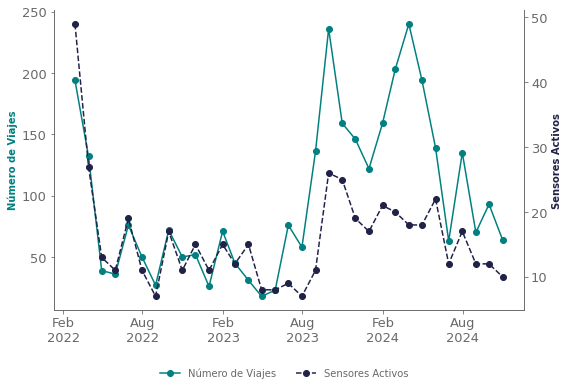

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'fecha' is datetime and set as index
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)

# 1. Monthly trips (viajes_tot)
Viajes = df.drop_duplicates(subset=['viajes_tot'])
Viajes['viajes_per'] = 1
Mes = Viajes.resample('1M').sum()
Mes['Número de Viajes'] = Mes['viajes_per']

# 2. Monthly active sensors
Sensores = df.groupby(pd.Grouper(freq='M'))['codigoSerial'].nunique()
Sensores = Sensores.to_frame(name='Sensores Activos')

# 3. Combine data
data_combined = pd.concat([Mes['Número de Viajes'], Sensores], axis=1)

# 4. Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary y-axis: Number of trips
color1 = 'teal'
ax1.set_ylabel('Número de Viajes', color=color1, fontdict=dict(weight='bold'))
ax1.plot(data_combined.index, data_combined['Número de Viajes'], color=color1, marker='o', label='Número de Viajes')
ax1.tick_params(axis='both', colors='dimgrey', labelsize=13)

# Secondary y-axis: Active sensors
ax2 = ax1.twinx()
color2 = '#202248'
ax2.set_ylabel('Sensores Activos', color=color2, fontdict=dict(weight='bold'))
ax2.plot(data_combined.index, data_combined['Sensores Activos'], color=color2, linestyle='--', marker='o', label='Sensores Activos')
ax2.tick_params(axis='both', colors='dimgrey', labelsize=13)

# X-axis formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Style adjustments
for spine in ax1.spines.values():
    spine.set_color('dimgrey')
for spine in ax2.spines.values():
    spine.set_color('dimgrey')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Legend
leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2, frameon=False)
for text in leg.get_texts():
    text.set_color('dimgrey')

# Save figure
plt.savefig(output_path + 'CCBicis_Historico.png', dpi=300, bbox_inches='tight')
plt.show()

# Module 6 — Retrieve Latest Monthly Values

Description:
This section retrieves the latest available data points from the monthly aggregated dataset:

    Número de Viajes: total bicycle trips for the most recent month.

    Sensores Activos: number of unique active sensors for the most recent month.

In [69]:
# Último dato de 'Número de Viajes' en el DataFrame 'Mes'
ultimo_viajes = Mes['Número de Viajes'].iloc[-1]
print(f"Último dato de 'Número de Viajes': {ultimo_viajes}")

# Último dato de 'Sensores Activos' en el DataFrame 'data_combined'
ultimo_sensores = data_combined['Sensores Activos'].iloc[-1]
print(f"Último dato de 'Sensores Activos': {ultimo_sensores}")


Último dato de 'Número de Viajes': 64
Último dato de 'Sensores Activos': 10


# Module 7 — Yearly Comparison of Monthly Trips and Active Sensors

Description:
This module visualizes how the number of bicycle trips and number of active sensors vary month-by-month for different years, enabling a direct comparison across 2022, 2023, and 2024.

The workflow:

    Monthly Trips

        Counts unique trip IDs (viajes_tot) per month.

    Monthly Active Sensors

        Counts unique sensor IDs (codigoSerial) per month.

    Separate Data by Year

        Filters the aggregated monthly dataset into three separate DataFrames (data_2022, data_2023, data_2024).

    Dual-axis Plot

        Left axis: Number of trips (solid/dashed colored lines per year).

        Right axis: Active sensors (solid/dashed colored lines per year).

        X-axis: Months from January to December.

/tmp/ipykernel_2825930/959945480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Viajes['viajes_per'] = 1
/tmp/ipykernel_2825930/959945480.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Mes = Viajes.resample('1M').sum()
/tmp/ipykernel_2825930/959945480.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Sensores = df.groupby(pd.Grouper(freq='M'))['codigoSerial'].nunique()


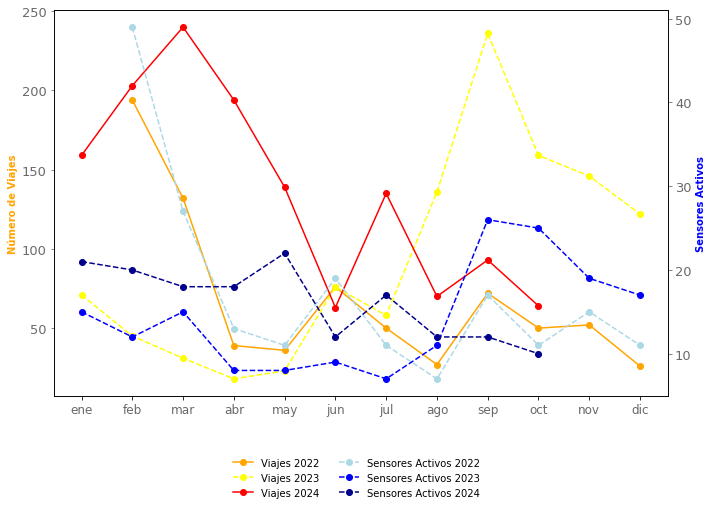

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Monthly trips
Viajes = df.drop_duplicates(subset=['viajes_tot'])
Viajes['viajes_per'] = 1
Mes = Viajes.resample('1M').sum()
Mes['Número de Viajes'] = Mes['viajes_per']

# 2. Monthly active sensors
Sensores = df.groupby(pd.Grouper(freq='M'))['codigoSerial'].nunique()
Sensores = Sensores.to_frame(name='Sensores Activos')

# 3. Combine and add month/year columns
data_combined = pd.concat([Mes['Número de Viajes'], Sensores], axis=1)
data_combined['Mes'] = data_combined.index.month
data_combined['Año'] = data_combined.index.year

# Filter by year
data_2022 = data_combined[data_combined['Año'] == 2022]
data_2023 = data_combined[data_combined['Año'] == 2023]
data_2024 = data_combined[data_combined['Año'] == 2024]

# 4. Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Trips per year
ax1.plot(data_2022['Mes'], data_2022['Número de Viajes'], label='Trips 2022', color='orange', marker='o')
ax1.plot(data_2023['Mes'], data_2023['Número de Viajes'], label='Trips 2023', color='yellow', linestyle='--', marker='o')
ax1.plot(data_2024['Mes'], data_2024['Número de Viajes'], label='Trips 2024', color='red', marker='o')

# Left Y-axis styling
ax1.set_ylabel('Number of Trips', color='orange', fontdict=dict(weight='bold'))
ax1.tick_params(axis='y', colors='dimgrey', labelsize=13)

# Sensors per year
ax2 = ax1.twinx()
ax2.plot(data_2022['Mes'], data_2022['Sensores Activos'], label='Active Sensors 2022', color='lightblue', linestyle='--', marker='o')
ax2.plot(data_2023['Mes'], data_2023['Sensores Activos'], label='Active Sensors 2023', color='blue', linestyle='--', marker='o')
ax2.plot(data_2024['Mes'], data_2024['Sensores Activos'], label='Active Sensors 2024', color='darkblue', linestyle='--', marker='o')

# Right Y-axis styling
ax2.set_ylabel('Active Sensors', color='blue', fontdict=dict(weight='bold'))
ax2.tick_params(axis='y', colors='dimgrey', labelsize=13)

# Month labels
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, color='dimgrey')

# Legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

# Layout
fig.tight_layout()
fig.set_facecolor('w')
plt.show()

# Module 8 — Monthly Trips-to-Active-Sensors Index

Description:
This module calculates and visualizes the Trips-to-Active-Sensors Index, which represents the ratio between the total number of bicycle trips and the number of active sensors for each month. This index allows for comparisons of trip activity levels normalized by sensor availability.

The workflow:

    Monthly Trips

        Counts unique trip IDs (viajes_tot) per month.

    Active Sensors

        Uses the pre-calculated Sensores DataFrame with monthly unique sensor counts.

    Merge & Calculate Index

        Merges monthly trips and sensor counts by month and year.

        Calculates the index:
        Index=Nuˊmero de ViajesSensores Activos
        Index=Sensores ActivosNuˊmero de Viajes​

    Filter by Year

        Creates separate datasets for 2022, 2023, and 2024.

    Plot

        X-axis: Months (Jan–Dec).

        Y-axis: Trips-to-Active-Sensors Index.

        Line colors distinguish each year.

/tmp/ipykernel_2825930/3664925234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Viajes['viajes_per'] = 1
/tmp/ipykernel_2825930/3664925234.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Mes = Viajes.resample('1M').sum()


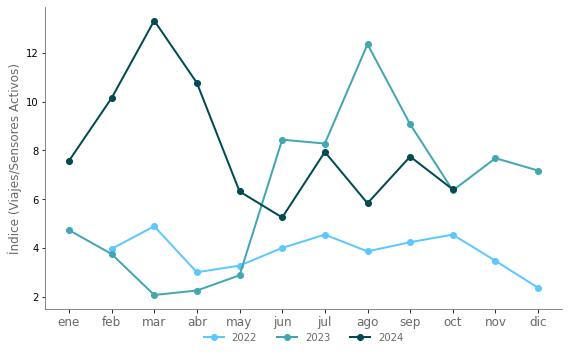

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Monthly trips
Viajes = df.drop_duplicates(subset=['viajes_tot'])
Viajes['viajes_per'] = 1
Mes = Viajes.resample('1M').sum()
Mes['Número de Viajes'] = Mes['viajes_per']

# 2. Extract month/year for merging
Mes['Mes'] = Mes.index.month
Mes['Año'] = Mes.index.year
Sensores['Mes'] = Sensores.index.month
Sensores['Año'] = Sensores.index.year

# 3. Merge datasets and calculate index
data_combined = pd.merge(
    Mes[['Número de Viajes', 'Mes', 'Año']],
    Sensores[['Sensores Activos', 'Mes', 'Año']],
    on=['Mes', 'Año']
)
data_combined['Trips/Sensors Index'] = data_combined['Número de Viajes'] / data_combined['Sensores Activos']

# 4. Filter by year
indice_2022 = data_combined[data_combined['Año'] == 2022]
indice_2023 = data_combined[data_combined['Año'] == 2023]
indice_2024 = data_combined[data_combined['Año'] == 2024]

# 5. Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(indice_2022['Mes'], indice_2022['Trips/Sensors Index'], label='2022', color='#5DC8FF', marker='o', linewidth=2)
ax.plot(indice_2023['Mes'], indice_2023['Trips/Sensors Index'], label='2023', color='#42a7b1', marker='o', linewidth=2)
ax.plot(indice_2024['Mes'], indice_2024['Trips/Sensors Index'], label='2024', color='#004a54', marker='o', linewidth=2)

# X-axis labels
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, color='dimgrey')

# Y-axis label
ax.set_ylabel('Trips-to-Active-Sensors Index', color='dimgrey', fontsize=12)

# Styling
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('dimgrey')

# Legend
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)
for text in leg.get_texts():
    text.set_color('dimgrey')

# Layout & save
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig(output_path + 'CCBici_Index.png', dpi=300, bbox_inches='tight')
plt.show()

# Module 9 — Daily PM2.5 Levels by Time Interval (October 2024)

Description:
This module analyzes PM2.5 concentration levels recorded by bicycle sensors during different time intervals of the day, for October 2024.
The data is split into 6 specific time ranges, averaged per day, and then plotted for visual comparison.

Workflow:

    Filter Data for October 2024

        Uses fechaHora as a datetime index.

        Selects only records from October 2024.

    Apply Time-of-Day Filters

        6:00–9:00

        9:00–12:00

        12:00–15:00

        15:00–18:00

        18:00–21:00

        21:00–23:00

        Each subset replaces PM2.5 values ≤ 0 with NaN.

    Daily Averaging

        Resamples each time range to daily means.

    Plotting

        Multiple time-series lines, one for each time range.

        Y-axis: PM2.5 concentration (µg/m³).

        X-axis: Days in October (month abbreviations).

/tmp/ipykernel_2825930/2526456819.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P["pm25_df"] = P["pm25_df"].where(P["pm25_df"] > 0.0, np.nan)
/tmp/ipykernel_2825930/2526456819.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S["pm25_df"] = S["pm25_df"].where(S["pm25_df"] > 0.0, np.nan)
/tmp/ipykernel_2825930/2526456819.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

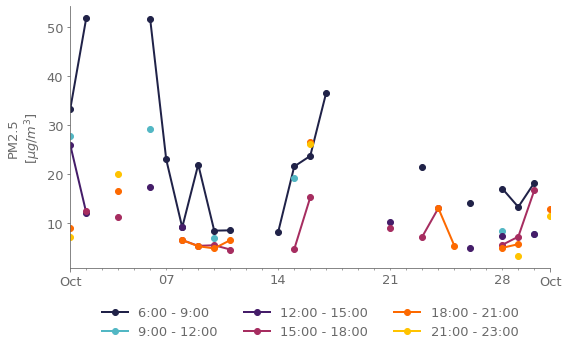

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

# Ensure datetime format and set as index
df['fechaHora'] = pd.to_datetime(df['fechaHora'], errors='coerce')
df.set_index('fechaHora', inplace=True)

# Filter for October 2024
df1 = df.loc[(df.index.month == 10) & (df.index.year == 2024)]

# Function to filter and resample PM2.5 by hour range
def filter_pm25(data, start_hour, end_hour, label):
    subset = data.loc[(data.index.hour >= start_hour) & (data.index.hour <= end_hour)]
    subset["pm25_df"] = subset["pm25_df"].where(subset["pm25_df"] > 0.0, np.nan)
    subset = subset['pm25_df'].to_frame(name=label)
    return subset.resample('D').mean()

# Time ranges
P = filter_pm25(df1, 6, 9, '6:00 - 9:00')
S = filter_pm25(df1, 9, 11, '9:00 - 12:00')
T = filter_pm25(df1, 11, 15, '12:00 - 15:00')
C = filter_pm25(df1, 15, 18, '15:00 - 18:00')
Q = filter_pm25(df1, 18, 21, '18:00 - 21:00')
Sx = filter_pm25(df1, 21, 23, '21:00 - 23:00')

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
P['6:00 - 9:00'].plot(ax=ax, color="#202248", marker='o', linewidth=2)
S['9:00 - 12:00'].plot(ax=ax, color="#52b7c4", marker='o', linewidth=2)
T['12:00 - 15:00'].plot(ax=ax, color="#451d69", marker='o', linewidth=2)
C['15:00 - 18:00'].plot(ax=ax, color="#a62d60", marker='o', linewidth=2)
Q['18:00 - 21:00'].plot(ax=ax, color="#fd6900", marker='o', linewidth=2)
Sx['21:00 - 23:00'].plot(ax=ax, color="#ffc300", marker='o', linewidth=2)

# Axis styling
ax.set_ylabel('PM2.5 [$\mu g/m^{3}$]', color='dimgrey', fontsize=13)
ax.tick_params(axis='both', colors='dimgrey', labelsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')

# X-axis format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# Legend styling
leg = plt.legend(bbox_to_anchor=(.5, -0.1), loc='upper center', fontsize=13, ncol=3, frameon=False)
for text in leg.get_texts():
    text.set_color('dimgrey')

# Layout & save
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig(output_path+'CCBici_Horas.png', dpi=300, bbox_inches='tight')
plt.show()

# Module 10 — Hourly Cycle of PM2.5 Concentrations

Description:
This module calculates and visualizes the average hourly variation of PM2.5 concentrations recorded by bicycle sensors. The result is a diurnal cycle plot, showing how air quality changes throughout a typical day based on the dataset.

Workflow:

    Clean Data

        Replace PM2.5 values ≤ 0 with NaN to avoid skewing averages.

    Hourly Averaging

        Resample the dataset to 1-hour intervals.

        Extract the hour of the day from the timestamp.

        Group by hour and compute the mean PM2.5 concentration.

    Plot

        X-axis: Hour of the day (00:00 to 21:00, every 3 hours).

        Y-axis: Average PM2.5 concentration (µg/m³).

        Styled with a teal line and markers for clarity.

/tmp/ipykernel_2825930/2521097198.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mes_hora = H.resample('1H').mean(numeric_only=True)


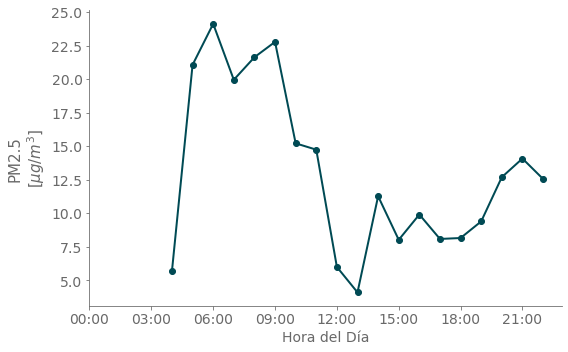

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Replace negative or zero PM2.5 with NaN
H = df1.copy()
H["pm25_df"] = H["pm25_df"].where(H["pm25_df"] > 0.0, np.nan)

# Hourly resampling
mes_hora = H.resample('1H').mean(numeric_only=True)
mes_hora['hora'] = mes_hora.index.hour

# Group by hour
CD = mes_hora.groupby('hora').mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
CD['pm25_df'].plot(ax=ax, color='#004a54', linestyle='-', marker='o', linewidth=2.)

# X-axis formatting
ax.set_xticks(np.arange(0, 24, 3))
ax.set_xticklabels([f"{h:02d}:00" for h in np.arange(0, 24, 3)])

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.set_xlabel('Hour of Day', fontsize=14, color='dimgrey')
ax.set_ylabel('PM2.5 [$\mu g/m^{3}$]', color='dimgrey', fontsize=15)
ax.tick_params(axis='both', colors='dimgrey', labelsize=14)

# Save figure
fig.tight_layout()
plt.savefig(output_path+'CCBicis_CD.png', dpi=300, bbox_inches='tight')
plt.show()



# Module 11 — PM2.5 Spatial Clustering and Heatmap Visualization

Description:
This module generates two geospatial visualizations for PM2.5 concentrations recorded by bicycle sensors:

    Cluster Map: Groups nearby data points using DBSCAN clustering and colors each cluster by its average PM2.5 concentration.

    Heatmap (KDE): Displays the density of PM2.5 data points using a kernel density estimation, highlighting spatial patterns of high and low measurement density.

Workflow:

    Geospatial Preparation

        Convert the DataFrame to a GeoDataFrame with EPSG:4326 coordinates.

        Transform to EPSG:3857 for tile compatibility with contextily.

    Clustering Analysis

        Apply DBSCAN clustering on projected coordinates.

        Calculate average PM2.5 concentration for each cluster.

        Merge with cluster geometries for mapping.

    Cluster Map

        Overlay cluster areas on the AMVA shapefile.

        Use a custom color map with PM2.5 concentration bins.

        Add base map tiles with reduced opacity.

    Heatmap (KDE)

        Reproject data to EPSG:4326 for KDE calculation.

        Compute kernel density estimation with increased resolution.

        Display results using a custom gradient color map over the AMVA boundary and base map.

/tmp/ipykernel_2825930/938073528.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)  # Ajustar el espacio entre subplots


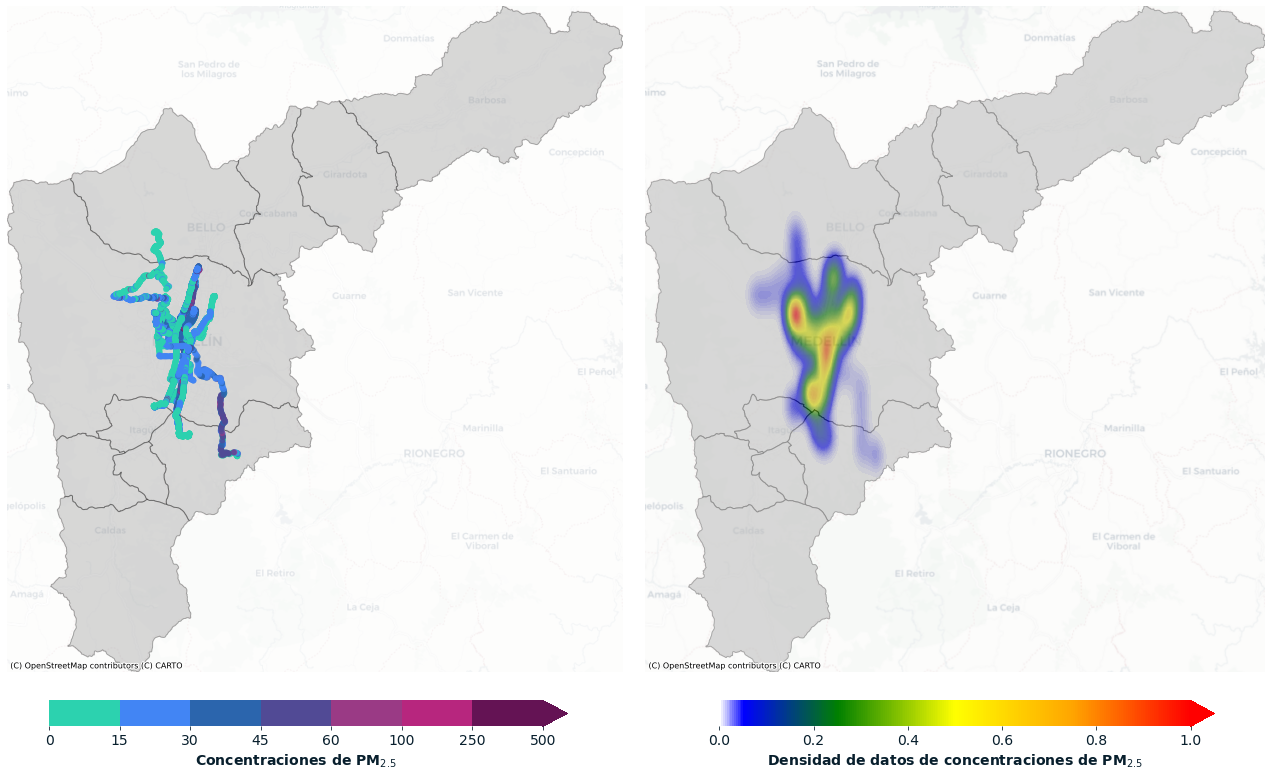

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitud.values, df1.latitud.values))
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)

# Extract coordinates for clustering
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
db = DBSCAN(eps=0.1, min_samples=1).fit(coords)
gdf['cluster'] = db.labels_

# Average PM2.5 per cluster
clustered_data = gdf.groupby('cluster')['pm25_df'].mean().reset_index()
clustered_data = clustered_data.rename(columns={'pm25_df': 'pm25_avg'})
clustered_geometry = gdf.dissolve(by='cluster').geometry.reset_index()
result = pd.merge(clustered_data, clustered_geometry, on='cluster')
result_gdf = gpd.GeoDataFrame(result, geometry='geometry')

# Load AMVA shapefile
shape_amva = gpd.read_file('/path/to/AreaMetropolitana.shp').to_crs(epsg=3857)

# Create figure with GridSpec
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=-0.2)

# --- First subplot: Cluster Map ---
ax1 = fig.add_subplot(gs[0, 0])
shape_amva.plot(ax=ax1, color='gray', edgecolor='black', linewidth=1, alpha=0.3)
colors = ['#2cd2af', '#4285f4', '#2b65ad', '#514a95', '#9a3a85', '#b7267e', '#641354']
bounds = [0, 15, 30, 45, 60, 100, 250, 500]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(colors))
result_gdf.plot(ax=ax1, column='pm25_avg', cmap=mcolors.ListedColormap(colors), norm=norm, alpha=0.7, edgecolor='none')
ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, alpha=0.3)
ax1.set_xlim(shape_amva.total_bounds[[0, 2]])
ax1.set_ylim(shape_amva.total_bounds[[1, 3]])
ax1.axis('off')
sm = plt.cm.ScalarMappable(cmap=mcolors.ListedColormap(colors), norm=norm)
cb = plt.colorbar(sm, ax=ax1, orientation='horizontal', fraction=0.036, pad=0.04, extend='max')
cb.set_label(r'PM$_{2.5}$ Concentrations', color='#081F2D', fontsize=14, fontweight='bold')
cb.ax.tick_params(colors='#081F2D', labelsize=14)

# --- Second subplot: Heatmap (KDE) ---
ax2 = fig.add_subplot(gs[0, 1])
gdf = gdf.to_crs(epsg=4326)
x, y = gdf.geometry.x, gdf.geometry.y
kde = gaussian_kde([x, y], bw_method=0.3)
xmin, ymin, xmax, ymax = shape_amva.to_crs(epsg=4326).total_bounds
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)
gradient = {'0.0': 'white', '0.05': 'blue', '0.25': 'green', '0.5': 'yellow', '0.75': 'orange', '1.0': 'red'}
colors = [(float(k), v) for k, v in gradient.items()]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
shape_amva.to_crs(epsg=4326).plot(ax=ax2, color='gray', edgecolor='black', linewidth=1, alpha=0.6)
ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, alpha=0.9)
ax2.imshow(np.rot90(f), cmap=custom_cmap, extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=2)
ax2.set_xlim(xmin + 0.0005, xmax - 0.0005)
ax2.set_ylim(ymin + 0.0005, ymax - 0.0005)
sm = plt.cm.ScalarMappable(cmap=custom_cmap)
cb = plt.colorbar(sm, ax=ax2, orientation='horizontal', fraction=0.036, pad=0.04, extend='both')
cb.set_label(r'PM$_{2.5}$ Data Density', color='#081F2D', fontsize=14, fontweight='bold')
cb.ax.tick_params(colors='#081F2D', labelsize=14)
ax2.axis('off')

# Save
plt.savefig(output_path+'CCBici_Mapas.png', dpi=300, bbox_inches='tight')
plt.show()


# Module 12 — Daily Active Sensors Count with Average Reference

Description:
This module calculates the number of unique active sensors per day and compares it to the daily average number of active sensors over the selected time period.
The result is a time series plot showing daily variations and the overall average as a reference line.

Workflow:

    Group and Count Sensors

        Groups data by day and counts unique codigoSerial values (one per sensor).

    Calculate Daily Average

        Computes the mean number of active sensors per day and rounds it to the nearest integer.

    Plot

        Solid teal line: Daily active sensors count.

        Dashed orange line: Overall daily average.

        X-axis: Date (formatted to show month and day).

        Y-axis: Number of sensors with data.

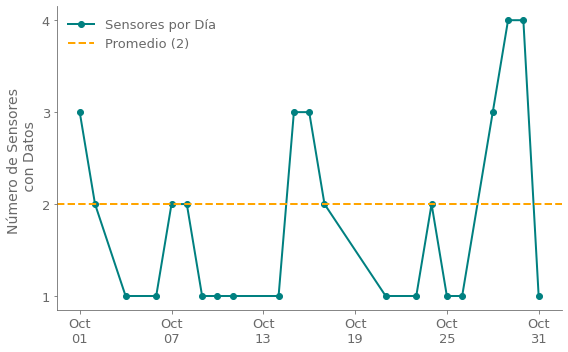

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

# Count unique sensors per day
sensores_por_dia = df1.groupby(df1.index.date)['codigoSerial'].nunique()

# Daily average
promedio_sensores = sensores_por_dia.mean().round()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
sensores_por_dia.plot(ax=ax, color='teal', marker='o', linestyle='-', linewidth=2, label='Sensors per Day')
ax.axhline(promedio_sensores, color='orange', linestyle='--', linewidth=2, label=f'Average ({promedio_sensores:.0f})')

# Labels and formatting
ax.set_ylabel('Number of Sensors\nwith Data', fontsize=14, color='dimgrey')
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.tick_params(axis='x', labelsize=13, colors='dimgrey')
ax.tick_params(axis='y', labelsize=13, colors='dimgrey')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
legend = ax.legend(frameon=False, fontsize=13)
for text in legend.get_texts():
    text.set_color('dimgrey')

# Save
plt.tight_layout()
plt.savefig(output_path + 'CCBici_Balance_Diario.png', dpi=300, bbox_inches='tight')
plt.show()

